# LSTM Models

In [530]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import warnings
import tabula
import pycountry
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from sklearn.model_selection import train_test_split

warnings.filterwarnings(action = 'ignore')
sns.set_style('whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [186]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


## Formatting the data

Unique airport/city combinations are treated as individual locations or airport nodes in this initial exercise.

Grouping the entire dataset by these variables allows us to observe the increase in number of confirmed cases for a given location.

In [830]:
df = pd.read_csv('time_series_cases.csv', index_col=0)
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8424 entries, 0 to 8423
Data columns (total 15 columns):
Province/State        8424 non-null object
city_county_state     8424 non-null object
country               8424 non-null object
hospital beds         8424 non-null float64
physicians            8424 non-null float64
GDP_per_capita        8424 non-null float64
SPAR_index            8424 non-null float64
IVDI_score            8424 non-null float64
city_pop              8424 non-null float64
effective_dist        8424 non-null float64
geo_dist              8424 non-null float64
ann_pass_flux         8424 non-null float64
connected_airports    8424 non-null float64
date                  8424 non-null datetime64[ns]
confirmed_cases       8424 non-null float64
dtypes: datetime64[ns](1), float64(11), object(3)
memory usage: 1.0+ MB


In [831]:
df = df.sort_values(by = ['Province/State', 'city_county_state', 'country', 'date'])
df.head()

,Province/State,city_county_state,country,hospital beds,physicians,GDP_per_capita,SPAR_index,IVDI_score,city_pop,effective_dist,geo_dist,ann_pass_flux,connected_airports,date,confirmed_cases
1144,0,", ,",San Marino,3.8,6.1468,13536.794829,32.846154,0.696439,811.05913,12.909125,8530.463669,3.312232e+06,54.719512,2019-12-08,0.0
5928,0,", ,",San Marino,3.8,6.1468,13536.794829,32.846154,0.696439,811.05913,12.909125,8530.463669,3.312232e+06,54.719512,2019-12-09,0.0
6032,0,", ,",San Marino,3.8,6.1468,13536.794829,32.846154,0.696439,811.05913,12.909125,8530.463669,3.312232e+06,54.719512,2019-12-10,0.0
1248,0,", ,",San Marino,3.8,6.1468,13536.794829,32.846154,0.696439,811.05913,12.909125,8530.463669,3.312232e+06,54.719512,2019-12-11,0.0
1352,0,", ,",San Marino,3.8,6.1468,13536.794829,32.846154,0.696439,811.05913,12.909125,8530.463669,3.312232e+06,54.719512,2019-12-12,0.0


In [779]:
# to replace timestamp with number of days indexing back to Dec 8th
dic = {}
for index, date in enumerate(df.date.unique()):
    x = {date : index}
    dic.update(x)

df.date = df.date.map(dic)

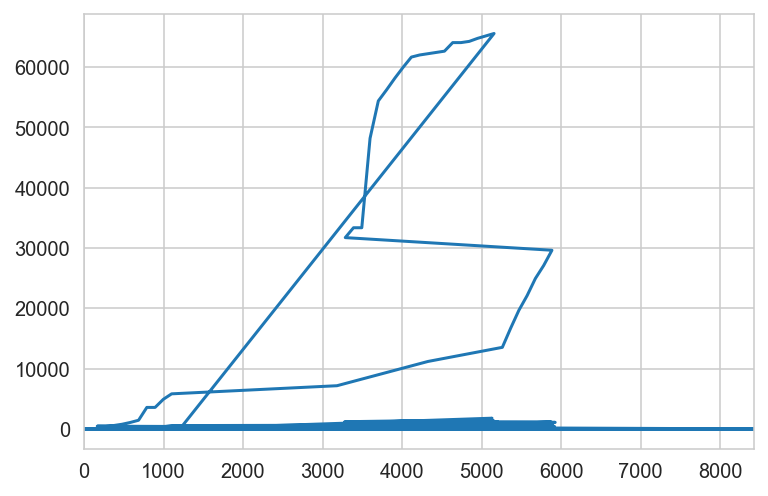

In [780]:
df.confirmed_cases.plot()

## Modeling Hubei Province, China

In [781]:
hubei_df = df.loc[df['Province/State'] == 'Hubei'].reset_index(drop=True)
hubei_df.head()

,Province/State,city_county_state,country,hospital beds,physicians,GDP_per_capita,SPAR_index,IVDI_score,city_pop,effective_dist,geo_dist,ann_pass_flux,connected_airports,date,confirmed_cases
0,Hubei,", Duodao District, Hubei",China,4.2,1.7855,18236.612982,94.307692,0.676294,1154.866872,6.111029,341.482235,2.842581e+06,29.033333,0,1.0
1,Hubei,", Duodao District, Hubei",China,4.2,1.7855,18236.612982,94.307692,0.676294,1154.866872,6.111029,341.482235,2.842581e+06,29.033333,1,0.0
2,Hubei,", Duodao District, Hubei",China,4.2,1.7855,18236.612982,94.307692,0.676294,1154.866872,6.111029,341.482235,2.842581e+06,29.033333,2,0.0
3,Hubei,", Duodao District, Hubei",China,4.2,1.7855,18236.612982,94.307692,0.676294,1154.866872,6.111029,341.482235,2.842581e+06,29.033333,3,2.0
4,Hubei,", Duodao District, Hubei",China,4.2,1.7855,18236.612982,94.307692,0.676294,1154.866872,6.111029,341.482235,2.842581e+06,29.033333,4,5.0


In [782]:
X = hubei_df.drop(columns = ['Province/State', 'city_county_state', 'country'])
Y = hubei_df.confirmed_cases

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.20, shuffle = False, random_state=2020)

In [783]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(64, 1, 12) (64,)
(17, 1, 12) (17,)


In [784]:
lag = 1
h_model = Sequential()
h_model.add(LSTM(units = 4, input_shape=(lag, trainX.shape[2])))
h_model.add(Dense(1))

In [785]:
h_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_32 (LSTM)               (None, 4)                 272       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 5         
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________


In [786]:
h_model.compile(loss='mean_squared_error', optimizer='adam')
h_model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1, validation_data = (testX, testY))

Train on 64 samples, validate on 17 samples
Epoch 1/20
64/64 [==============================] - 2s 33ms/step - loss: 75654758.5417 - val_loss: 3425396645.6471
Epoch 2/20
64/64 [==============================] - 0s 4ms/step - loss: 75654293.0236 - val_loss: 3425389417.4118
Epoch 3/20
64/64 [==============================] - 0s 4ms/step - loss: 75653844.5283 - val_loss: 3425381300.7059
Epoch 4/20
64/64 [==============================] - 0s 5ms/step - loss: 75653391.0624 - val_loss: 3425373199.0588
Epoch 5/20
64/64 [==============================] - 0s 4ms/step - loss: 75652908.5046 - val_loss: 3425366904.4706
Epoch 6/20
64/64 [==============================] - 0s 4ms/step - loss: 75652455.9075 - val_loss: 3425358817.8824
Epoch 7/20
64/64 [==============================] - 0s 4ms/step - loss: 75651981.8442 - val_loss: 3425351559.5294
Epoch 8/20
64/64 [==============================] - 0s 4ms/step - loss: 75651520.6457 - val_loss: 3425343427.7647
Epoch 9/20
64/64 [=========================

In [787]:
trainPredict = h_model.predict(trainX)
testPredict = h_model.predict(testX)

In [788]:
trainPredict = list(trainPredict)
testPredict = list(testPredict)

train_dates = list(hubei_df.date[0 : int(0.8*len(hubei_df))])
test_dates = list(hubei_df.date[int(0.8*len(hubei_df))-1 : -1])

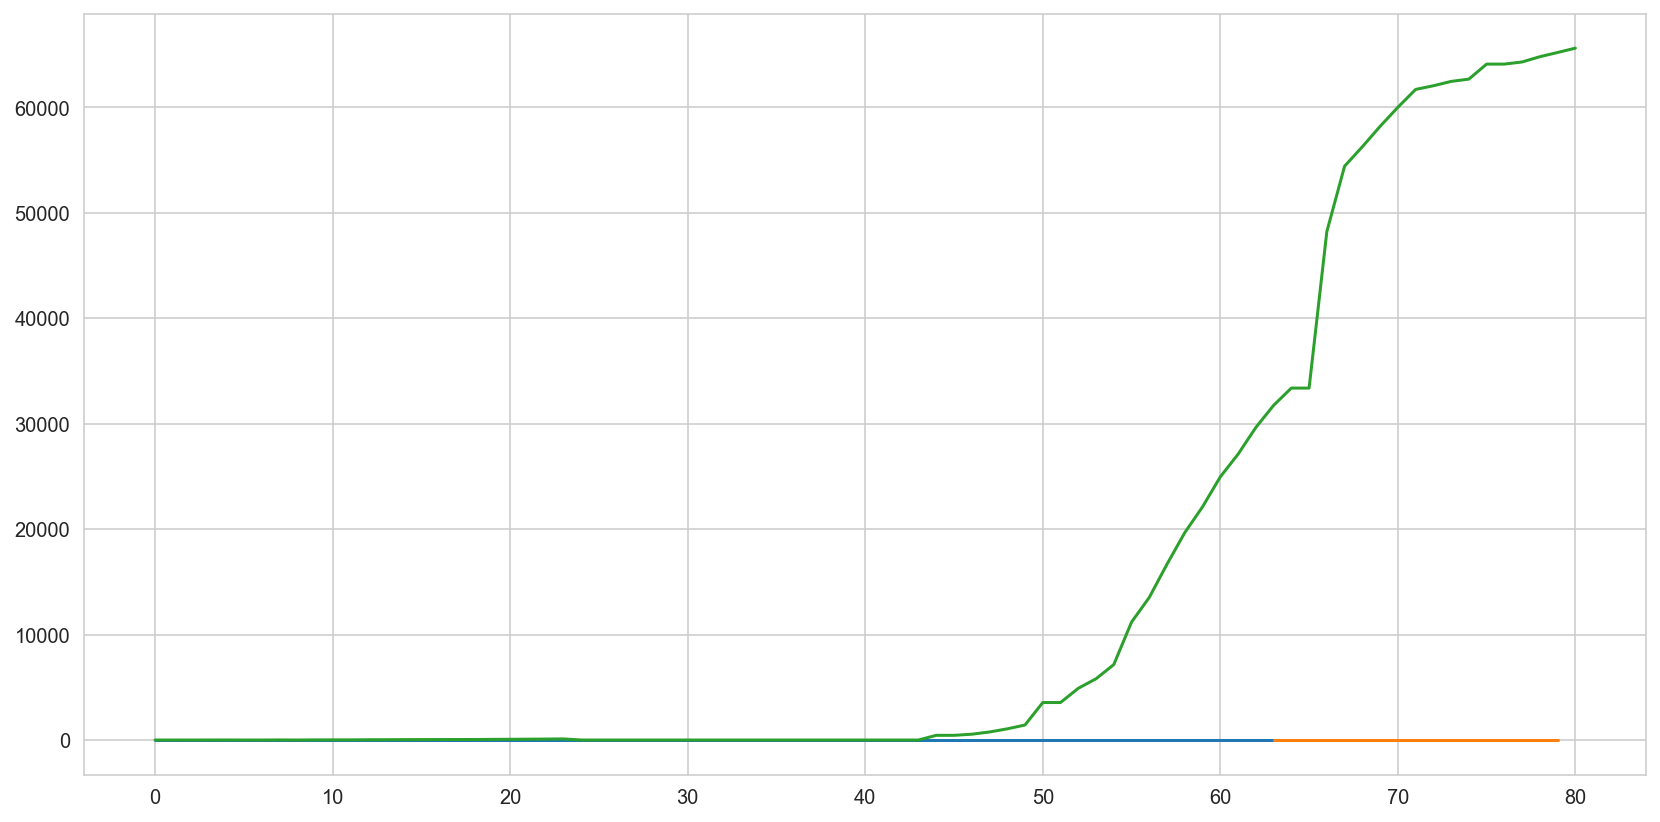

In [789]:
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(train_dates, trainPredict)
plt.plot(test_dates, testPredict)
plt.plot(hubei_df.date, hubei_df.confirmed_cases)
plt.show()

## Modeling China, all provinces

In [790]:
china_df = df.loc[df['country'] == 'China'].reset_index(drop=True)
china_df.head()

,Province/State,city_county_state,country,hospital beds,physicians,GDP_per_capita,SPAR_index,IVDI_score,city_pop,effective_dist,geo_dist,ann_pass_flux,connected_airports,date,confirmed_cases
0,Anhui,"Lianhua Community, 合肥政务文化新区, Anhui",China,4.2,1.7855,18236.612982,94.307692,0.676294,1389.908204,5.802647,483.46519,4.596527e+06,35.288462,0,0.0
1,Anhui,"Lianhua Community, 合肥政务文化新区, Anhui",China,4.2,1.7855,18236.612982,94.307692,0.676294,1389.908204,5.802647,483.46519,4.596527e+06,35.288462,1,0.0
2,Anhui,"Lianhua Community, 合肥政务文化新区, Anhui",China,4.2,1.7855,18236.612982,94.307692,0.676294,1389.908204,5.802647,483.46519,4.596527e+06,35.288462,2,0.0
3,Anhui,"Lianhua Community, 合肥政务文化新区, Anhui",China,4.2,1.7855,18236.612982,94.307692,0.676294,1389.908204,5.802647,483.46519,4.596527e+06,35.288462,3,0.0
4,Anhui,"Lianhua Community, 合肥政务文化新区, Anhui",China,4.2,1.7855,18236.612982,94.307692,0.676294,1389.908204,5.802647,483.46519,4.596527e+06,35.288462,4,0.0


In [804]:
X = china_df.drop(columns = ['Province/State', 'city_county_state', 'country'])
Y = china_df.confirmed_cases

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.20, shuffle = False, random_state=2020)

In [805]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(2008, 1, 12) (2008,)
(503, 1, 12) (503,)


In [806]:
lag = 1
c_model = Sequential()
c_model.add(LSTM(units = 4, input_shape=(lag, trainX.shape[2])))
c_model.add(Dense(1))

In [807]:
c_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_34 (LSTM)               (None, 4)                 272       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 5         
Total params: 277
Trainable params: 277
Non-trainable params: 0
_________________________________________________________________


In [795]:
c_model.compile(loss='mean_squared_error', optimizer='adam')
c_model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1, validation_data = (testX, testY))

Train on 2008 samples, validate on 503 samples
Epoch 1/20
2008/2008 [==============================] - 11s 5ms/step - loss: 31496731.2151 - val_loss: 77656.8458
Epoch 2/20
2008/2008 [==============================] - 9s 5ms/step - loss: 31496102.9665 - val_loss: 77562.2227
Epoch 3/20
2008/2008 [==============================] - 9s 5ms/step - loss: 31495433.6252 - val_loss: 77461.7847
Epoch 4/20
2008/2008 [==============================] - 8s 4ms/step - loss: 31494766.7078 - val_loss: 77365.5253
Epoch 5/20
2008/2008 [==============================] - 9s 4ms/step - loss: 31494115.1638 - val_loss: 77268.1478
Epoch 6/20
2008/2008 [==============================] - 8s 4ms/step - loss: 31493477.4960 - val_loss: 77176.1218
Epoch 7/20
2008/2008 [==============================] - 7s 4ms/step - loss: 31492823.3391 - val_loss: 77077.5674
Epoch 8/20
2008/2008 [==============================] - 7s 3ms/step - loss: 31492165.2100 - val_loss: 76984.2236
Epoch 9/20
2008/2008 [==========================

In [808]:
trainPredict = c_model.predict(trainX)
testPredict = c_model.predict(testX)

trainPredict = list(trainPredict)
testPredict = list(testPredict)

train_dates = list(china_df.date[0 : int(0.8*len(china_df))])
test_dates = list(china_df.date[int(0.8*len(china_df))-1 : -1])

In [817]:
preds = trainPredict + testPredict
preds[0:-1:100]

[array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32),
 array([0.83712506], dtype=float32)]

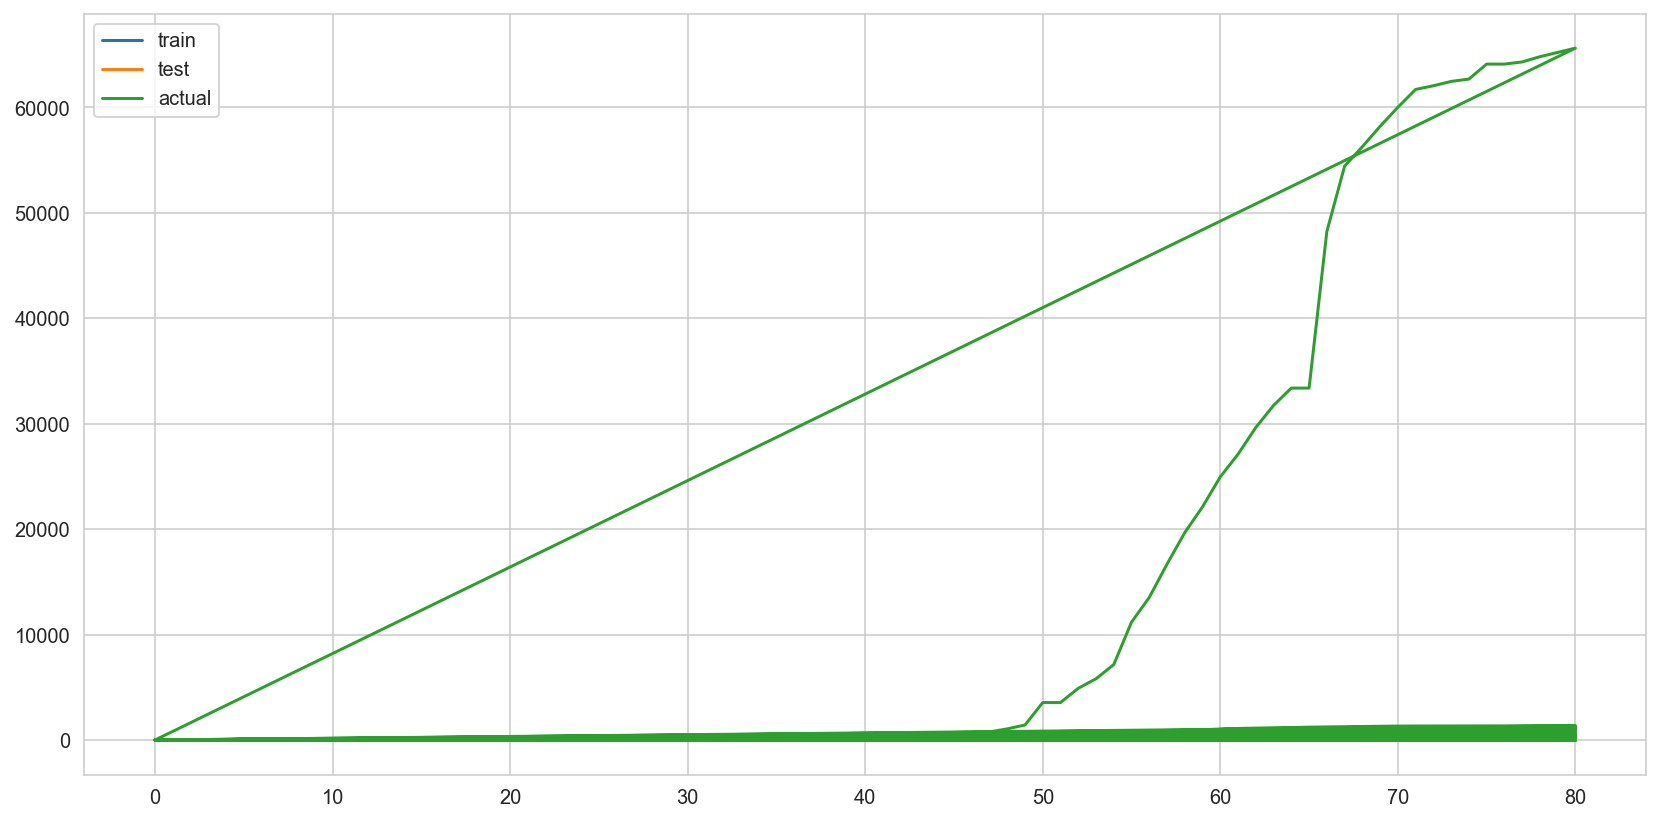

In [818]:
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(train_dates, trainPredict, label = 'train')
plt.plot(test_dates, testPredict, label = 'test')
plt.plot(china_df.date, china_df.confirmed_cases, label = 'actual')
plt.legend()
plt.show()

## Creating lags using a sliding window

In [750]:
# for lags in LSTM model

def create_data(timeseries, lag=1, as_array=True):
    if not isinstance(timeseries, pd.Series):
        timeseries = pd.Series(timeseries.ravel())
    y = timeseries[lag:]
    X = pd.DataFrame({'lag'+str(lag-i):timeseries.shift(-i) for i in range(0, lag)}).dropna().iloc[0:-1, :]
    if not as_array:
        return X, y
    else:
        return X.values, y.values

In [832]:
# rerun first two formatting data cells in notebook

train_size = int(len(df) * 0.50)
test_size = len(df) - train_size
print(len(df), train_size, test_size)

train, test = df.iloc[0:train_size,:].reset_index(drop=True), df.iloc[train_size:len(df),:].reset_index(drop=True)

8424 4212 4212


### Lag = 1, full dataset

This should be no different than the previous models except using the full dataset rather than specific locations.

In [833]:
lag = 1
trainX, trainY = create_data(train.confirmed_cases, lag)
testX, testY = create_data(test.confirmed_cases, lag)

In [834]:
print(trainX.shape, testX.shape)

(4211, 1) (4211, 1)


In [835]:
trainX = trainX.reshape((len(trainX)))
testX = testX.reshape((len(testX)))
print(trainX.shape, testX.shape)
type(trainX)

(4211,) (4211,)


numpy.ndarray

In [836]:
# concatenate values for three (lag #) time steps with the rest of static data

trainX = pd.concat([train.drop(columns = ['date',
                                          'confirmed_cases',
                                          'city_county_state',
                                          'Province/State', 
                                          'country']).iloc[:], 
                    pd.Series(trainX)],
                  axis = 1)

testX = pd.concat([test.drop(columns = ['date',
                                          'confirmed_cases',
                                          'city_county_state',
                                          'Province/State', 
                                          'country']).iloc[:],
                   pd.Series(testX)],
                 axis = 1)

In [837]:
print(trainX.shape, testX.shape)

(4212, 11) (4212, 11)


In [838]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX.values, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX.values, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(4212, 1, 11) (4211,)
(4212, 1, 11) (4211,)


In [839]:
model = Sequential()
model.add(LSTM(units = 4, input_shape=(lag, trainX.shape[2])))
model.add(Dense(1))

In [840]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 4)                 256       
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 5         
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________


In [843]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX[lag-1 :-1], trainY, epochs=20, batch_size=1, verbose=1)

Epoch 1/20
4211/4211 [==============================] - 20s 5ms/step - loss: 10152.1718
Epoch 2/20
4211/4211 [==============================] - 15s 4ms/step - loss: 10113.7337: 0s - loss: 10141.37
Epoch 3/20
4211/4211 [==============================] - 15s 3ms/step - loss: 10080.4548
Epoch 4/20
4211/4211 [==============================] - 15s 3ms/step - loss: 10051.3150
Epoch 5/20
4211/4211 [==============================] - 15s 3ms/step - loss: 10026.7268
Epoch 6/20
4211/4211 [==============================] - 15s 4ms/step - loss: 10005.9922
Epoch 7/20
4211/4211 [==============================] - 22s 5ms/step - loss: 9987.4664
Epoch 8/20
4211/4211 [==============================] - 17s 4ms/step - loss: 9971.8737
Epoch 9/20
4211/4211 [==============================] - 17s 4ms/step - loss: 9957.8023A: 
Epoch 10/20
4211/4211 [==============================] - 15s 4ms/step - loss: 9945.8818
Epoch 11/20
4211/4211 [==============================] - 14s 3ms/step - loss: 9935.4644
Epoch 12/20

In [844]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = list(trainPredict)
testPredict = list(testPredict)

train_dates = list(df.date[0 : int(0.5*len(df))])
test_dates = list(df.date[int(0.5*len(df))-1 : -1])

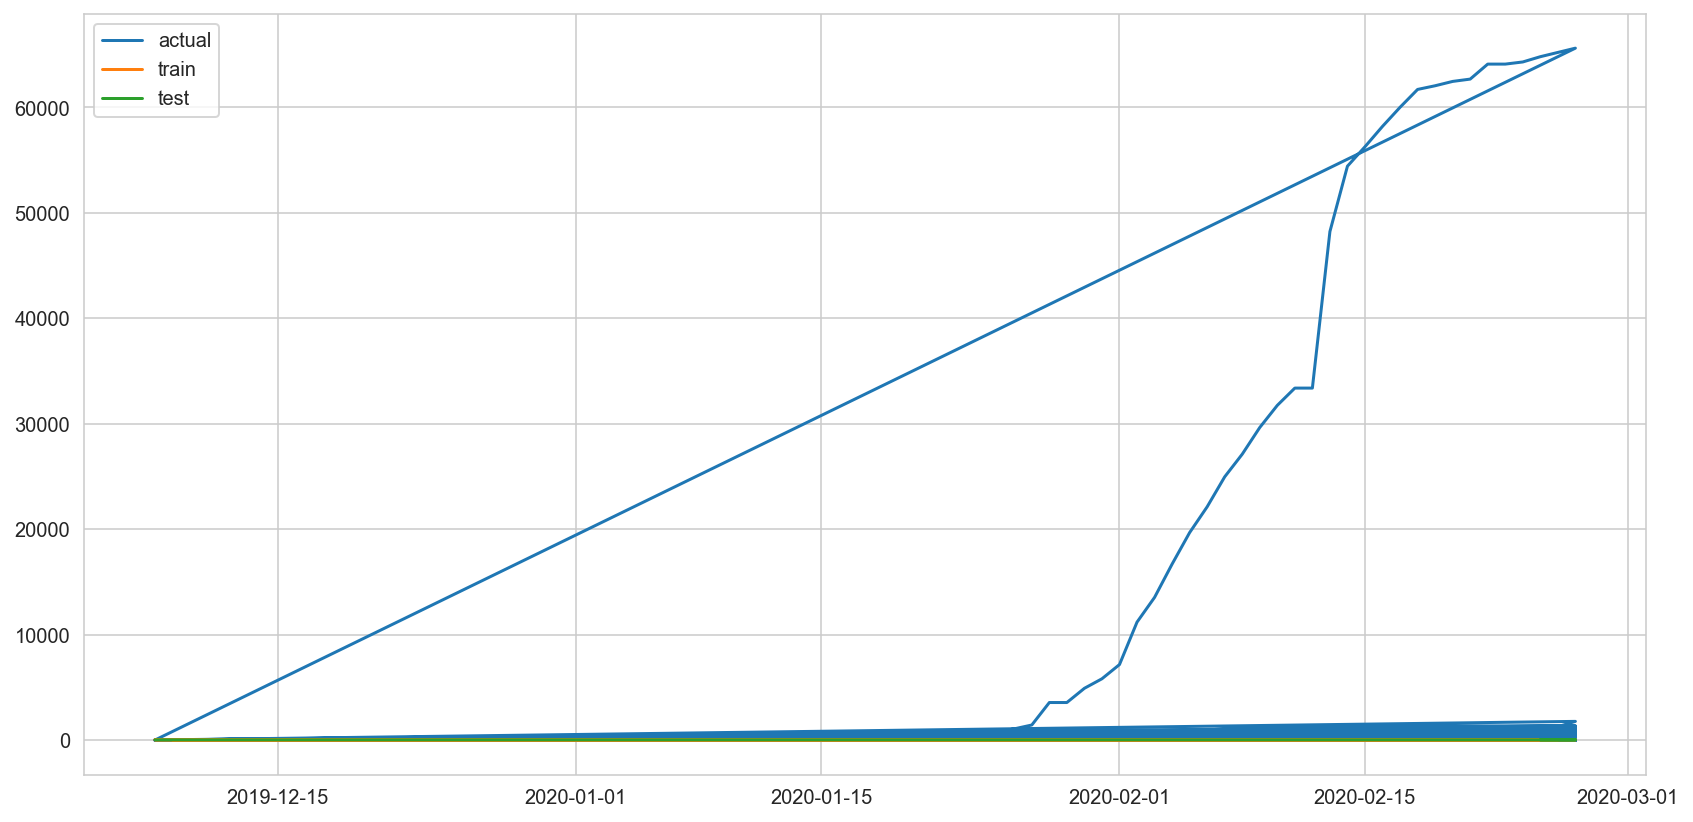

In [847]:
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(df.date, df.confirmed_cases, label = 'actual')
plt.plot(train_dates[lag:], trainPredict[lag:len(trainPredict)+lag], label = 'train')
plt.plot(test_dates[lag:], testPredict[lag:len(trainPredict)+lag], label = 'test')
plt.legend()
plt.show()

### Lag = 3, China only

In [896]:
# prep china dataset
train_size = int(len(china_df) * 0.50)
test_size = len(china_df) - train_size
print(len(china_df), train_size, test_size)

train, test = china_df.iloc[:train_size, :].reset_index(drop=True), china_df.iloc[(train_size-1):len(china_df),:].reset_index(drop=True)

lag = 3
trainX, trainY = create_data(train.confirmed_cases, lag)
testX, testY = create_data(test.confirmed_cases, lag)

2511 1255 1256


In [897]:
print(trainX.shape, testX.shape)

(1252, 3) (1254, 3)


In [898]:
trainX = pd.concat([train.drop(columns = ['date',
                                          'confirmed_cases',
                                          'city_county_state',
                                          'Province/State', 
                                          'country']).iloc[lag-1:-1], 
                    pd.DataFrame(trainX).iloc[lag-1:-1]],
                  axis = 1)

testX = pd.concat([test.drop(columns = ['date',
                                          'confirmed_cases',
                                          'city_county_state',
                                          'Province/State', 
                                          'country']).iloc[lag-1:-1],
                   pd.DataFrame(testX).iloc[lag-1:-1]],
                 axis = 1)

In [899]:
trainX.shape

(1252, 13)

In [900]:
trainX = np.reshape(trainX.values, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX.values, (testX.shape[0], testX.shape[1], 1))

print(trainX.shape, testX.shape, trainY.shape, testY.shape)

(1252, 13, 1) (1254, 13, 1) (1252,) (1254,)


In [901]:
model = Sequential()
model.add(LSTM(units = 4, batch_input_shape=(None, trainX.shape[1], 1)))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=1)

Epoch 1/20
1252/1252 [==============================] - 23s 18ms/step - loss: nan
Epoch 2/20
1252/1252 [==============================] - 19s 16ms/step - loss: nan
Epoch 3/20
1252/1252 [==============================] - 19s 15ms/step - loss: nan
Epoch 4/20
1252/1252 [==============================] - 19s 15ms/step - loss: nan
Epoch 5/20
1252/1252 [==============================] - 20s 16ms/step - loss: nan
Epoch 6/20
1252/1252 [==============================] - 18s 14ms/step - loss: nan
Epoch 7/20
1252/1252 [==============================] - 18s 14ms/step - loss: nan
Epoch 8/20
1252/1252 [==============================] - 18s 15ms/step - loss: nan
Epoch 9/20
1252/1252 [==============================] - 18s 14ms/step - loss: nan
Epoch 10/20
1252/1252 [==============================] - 18s 14ms/step - loss: nan
Epoch 11/20
1252/1252 [==============================] - 17s 14ms/step - loss: nan
Epoch 12/20
1252/1252 [==============================] - 18s 14ms/step - loss: nan
Epoch 13/20
1

In [902]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = list(trainPredict)
testPredict = list(testPredict)

train_dates = list(china_df.date[0 : int(0.5*len(china_df))])
test_dates = list(china_df.date[int(0.5*len(china_df))-1 : -1])

In [915]:
len(test_dates[lag-1:])

1254

In [912]:
len(testPredict)

1254

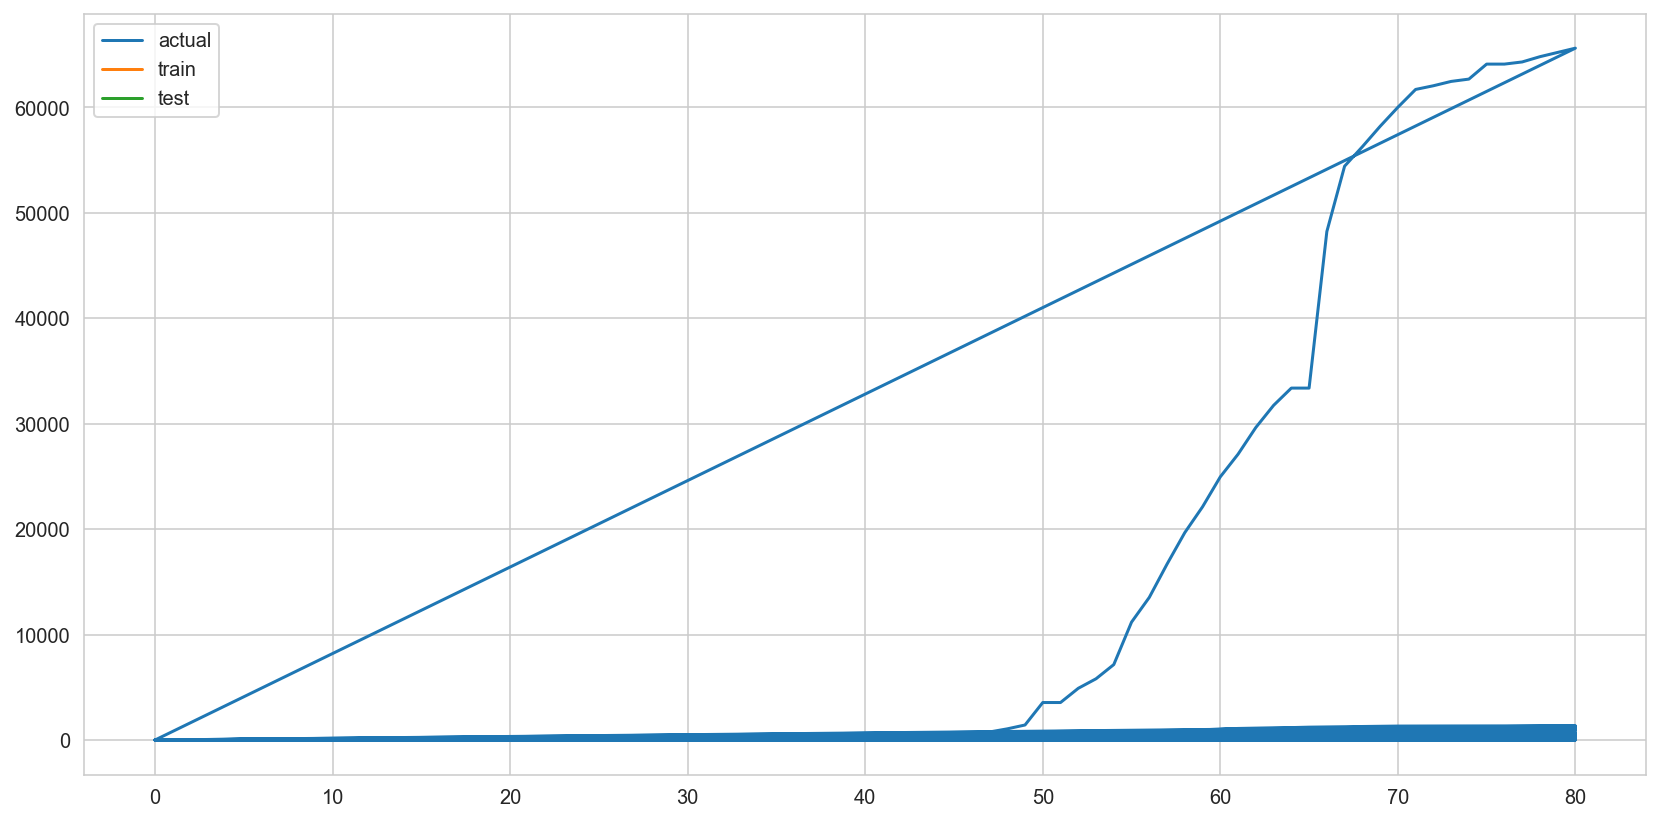

In [916]:
# plot baseline and predictions
plt.figure(figsize=(14,7))
plt.plot(china_df.date, china_df.confirmed_cases, label = 'actual')
plt.plot(train_dates[lag:], trainPredict, label = 'train')
plt.plot(test_dates[lag-1:], testPredict, label = 'test')
plt.legend()
plt.show()